# GPT-Models For SQL & Python

## Introduction

**Learning Goals:**

- Understand the scope of the notebook.
- Familiarize yourself with what GPT models can do in the context of SQL and Python.

## Setting Up the Environment

In this section, we'll import the required Python libraries and connect to a sample SQL database to prepare our environment for the tasks ahead.

In [ ]:
import sqlite3
import pandas as pd

# Connect to the database
db_connection = sqlite3.connect('sample_warehouse.db')

In [ ]:
pd.read_sql(sql = 'SELECT * FROM customers LIMIT 5',
            con = db_connection)

,customer_id,first_name,last_name,email
0,1,John,Doe,john.doe@example.com
1,2,Jane,Doe,jane.doe@example.com
2,3,Emily,Smith,emily.smith@example.com
3,4,Michael,Johnson,michael.johnson@example.com
4,5,Corey,Lara,acummings@thompson-bruce.biz


## Exploring the Database & Collecting Metadata for ChatGPT

Here, we'll explore the database's tables and their relationships. We'll use SQL queries to get a better understanding of the data structure.

In [ ]:
# Connect to the SQLite database
cursor = db_connection.cursor()

# Query to get all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
tables

[('customers',), ('sqlite_sequence',), ('products',), ('date',), ('sales',)]

In [ ]:
def list_tables_and_relationships(conn):
    cursor = conn.cursor()

    # Fetch all table names
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    # Dictionary to store table relationships
    relationships = {}

    # Loop through tables to find their relationships
    for table in tables:
        table = table[0]
        cursor.execute(f"PRAGMA foreign_key_list({table});")
        foreign_keys = cursor.fetchall()

        # Each item in foreign_keys is a tuple containing information about foreign keys.
        # For example: (0, 'main', 'products', 'product_id', 'product_id', 'NO ACTION', 'NO ACTION', 'NONE')
        relationships[table] = []
        for fk in foreign_keys:
            relationships[table].append({
                'table': fk[2],
                'from_column': fk[3],
                'to_column': fk[4]
            })

    # Close the connection
    conn.close()

    return relationships

def list_table_schemas(conn):
    cursor = conn.cursor()

    # Fetch all table names
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    # Dictionary to store table schemas
    schemas = {}

    # Loop through tables to find their columns and types
    for table in tables:
        table = table[0]
        cursor.execute(f"PRAGMA table_info({table});")
        columns = cursor.fetchall()

        # Each item in columns is a tuple containing information about the column.
        schemas[table] = []
        for column in columns:
            schemas[table].append({
                'name': column[1],
                'type': column[2]
            })

    return schemas

## Use Case 1: ChatGPT for Code Explanation

This section focuses on how ChatGPT can assist in explaining Python and SQL code.

Copy & paste the following prompt into ChatGPT following by the code you want explanations for:

```
ROLE: You're a world-class Python tutor.
TASK: Walk me through the Python code I give you. Explain it step by step. My Python level is Novice.
FORMAT: Return a chunk of code, followed by an explanation appropriate to my experience level in non-technical language. Skip the pre and post text.

Here's the code:
```

In [ ]:
# Fetch and display the schemas
schemas = list_table_schemas(db_connection)
schemas

{'customers': [{'name': 'customer_id', 'type': 'INTEGER'},
  {'name': 'first_name', 'type': 'TEXT'},
  {'name': 'last_name', 'type': 'TEXT'},
  {'name': 'email', 'type': 'TEXT'}],
 'sqlite_sequence': [{'name': 'name', 'type': ''},
  {'name': 'seq', 'type': ''}],
 'products': [{'name': 'product_id', 'type': 'INTEGER'},
  {'name': 'product_name', 'type': 'TEXT'},
  {'name': 'price', 'type': 'REAL'}],
 'date': [{'name': 'date_id', 'type': 'INTEGER'},
  {'name': 'day', 'type': 'INTEGER'},
  {'name': 'month', 'type': 'INTEGER'},
  {'name': 'year', 'type': 'INTEGER'}],
 'sales': [{'name': 'sale_id', 'type': 'INTEGER'},
  {'name': 'customer_id', 'type': 'INTEGER'},
  {'name': 'product_id', 'type': 'INTEGER'},
  {'name': 'date_id', 'type': 'INTEGER'},
  {'name': 'amount', 'type': 'REAL'}]}

In [ ]:
# Fetch and display the relationships
relationships = list_tables_and_relationships(db_connection)
relationships

{'customers': [],
 'sqlite_sequence': [],
 'products': [],
 'date': [],
 'sales': [{'table': 'date', 'from_column': 'date_id', 'to_column': 'date_id'},
  {'table': 'products',
   'from_column': 'product_id',
   'to_column': 'product_id'},
  {'table': 'customers',
   'from_column': 'customer_id',
   'to_column': 'customer_id'}]}

* The customers, products, and date tables do not have any foreign key relationships pointing to other tables.

* The sales table has foreign keys that establish relationships with the following tables:
  * A foreign key relationship to the date table through the date_id column.
  * A foreign key relationship to the products table through the product_id column.
  * A foreign key relationship to the customers table through the customer_id column.

## Use Case 2: Automating SQL Code Generation with GPT

In this section, we'll see how GPT models can assist in generating SQL code. We'll also go through the setup process for using OpenAI's API.

In [ ]:
# Option 1: Set the API key locally
import os
api_key = input("Enter your API key: ")
os.environ["API_KEY"] = api_key

Enter your API key: 


In [ ]:
# Option 2: Set the API key via colab
from google.colab import userdata
api_key = userdata.get('API_KEY')

In [ ]:
# Install openai package
!pip install openai

In [ ]:
# Import openai package and register API key
import openai
import json
client = openai.Client(api_key = api_key)

In [ ]:
# Define system prompt

system_prompt = """

ROLE: You are a SQL expert.

TASK: I'll give you the list of tables and relationships of my SQLite database.
You will take my natural langauge query and translate it into a functional SQL query for this database.

CONTEXT: ## Tables and relationships in triple backticks:
```
{'customers': [],
 'sqlite_sequence': [],
 'products': [],
 'date': [],
 'sales': [{'table': 'date', 'from_column': 'date_id', 'to_column': 'date_id'},
  {'table': 'products',
   'from_column': 'product_id',
   'to_column': 'product_id'},
  {'table': 'customers',
   'from_column': 'customer_id',
   'to_column': 'customer_id'}]}
```

## Table schemas in triple backticks:
```
{'customers': [{'name': 'customer_id', 'type': 'INTEGER'},
  {'name': 'first_name', 'type': 'TEXT'},
  {'name': 'last_name', 'type': 'TEXT'},
  {'name': 'email', 'type': 'TEXT'}],
 'sqlite_sequence': [{'name': 'name', 'type': ''},
  {'name': 'seq', 'type': ''}],
 'products': [{'name': 'product_id', 'type': 'INTEGER'},
  {'name': 'product_name', 'type': 'TEXT'},
  {'name': 'price', 'type': 'REAL'}],
 'date': [{'name': 'date_id', 'type': 'INTEGER'},
  {'name': 'day', 'type': 'INTEGER'},
  {'name': 'month', 'type': 'INTEGER'},
  {'name': 'year', 'type': 'INTEGER'}],
 'sales': [{'name': 'sale_id', 'type': 'INTEGER'},
  {'name': 'customer_id', 'type': 'INTEGER'},
  {'name': 'product_id', 'type': 'INTEGER'},
  {'name': 'date_id', 'type': 'INTEGER'},
  {'name': 'amount', 'type': 'REAL'}]}
```

OUTPUT: Return only the SQL query. Skip pre- and post text.

"""

Run the first simple SQL query:

In [ ]:
response = client.chat.completions.create(
  model="gpt-3.5-turbo-0613",
  messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": "How many customers are in the system?"}
  ],
  temperature=0.0,
)

json.loads(response.json())

{'id': 'chatcmpl-9SNRyAGYFZdsi52Ta8E4dqbg2ANV6',
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'logprobs': None,
   'message': {'content': 'SELECT COUNT(*) FROM customers;',
    'role': 'assistant',
    'function_call': None,
    'tool_calls': None}}],
 'created': 1716550354,
 'model': 'gpt-3.5-turbo-0613',
 'object': 'chat.completion',
 'system_fingerprint': None,
 'usage': {'completion_tokens': 6, 'prompt_tokens': 457, 'total_tokens': 463}}

Extract the SQL query from the completion object

In [ ]:
print(response.choices[0].message.content)

SELECT COUNT(*) FROM customers;


In [ ]:
sql_query = response.choices[0].message.content
sql_query

'SELECT COUNT(*) FROM customers;'

**New:** Use [JSON mode](https://platform.openai.com/docs/guides/text-generation/json-mode) - this returns a JSON output instead. Must instruct the model to produce JSON via some message in the conversation!

In [ ]:
response = client.chat.completions.create(
  model="gpt-3.5-turbo-1106",
  response_format={ "type": "json_object" },
  messages=[
    {"role": "system", "content": system_prompt + "Respond in JSON"},
    {"role": "user", "content": "How many customers are in the system?"}
  ],
  temperature=0.0,
)

json.loads(response.choices[0].message.content)['sql_query']

'SELECT COUNT(*) FROM customers;'

### Run script inside Python code

In [ ]:
db_connection = sqlite3.connect('sample_warehouse.db')
pd.read_sql(sql = sql_query,
            con = db_connection)

,COUNT(*)
0,54


Pull it all together to a single function for easier use:

In [ ]:
def sql_gpt(natural_language_query):
  system_prompt = """

  ROLE: You are a SQL expert.

  TASK: I'll give you the list of tables and relationships of my SQLite database.
  You will take my natural langauge query and translate it into a functional SQL query for this database.

  CONTEXT: ## Tables and relationships in triple backticks:
  ```
  {'customers': [],
  'sqlite_sequence': [],
  'products': [],
  'date': [],
  'sales': [{'table': 'date', 'from_column': 'date_id', 'to_column': 'date_id'},
    {'table': 'products',
    'from_column': 'product_id',
    'to_column': 'product_id'},
    {'table': 'customers',
    'from_column': 'customer_id',
    'to_column': 'customer_id'}]}
  ```

  ## Table schemas in triple backticks:
  ```
  {'customers': [{'name': 'customer_id', 'type': 'INTEGER'},
    {'name': 'first_name', 'type': 'TEXT'},
    {'name': 'last_name', 'type': 'TEXT'},
    {'name': 'email', 'type': 'TEXT'}],
  'sqlite_sequence': [{'name': 'name', 'type': ''},
    {'name': 'seq', 'type': ''}],
  'products': [{'name': 'product_id', 'type': 'INTEGER'},
    {'name': 'product_name', 'type': 'TEXT'},
    {'name': 'price', 'type': 'REAL'}],
  'date': [{'name': 'date_id', 'type': 'INTEGER'},
    {'name': 'day', 'type': 'INTEGER'},
    {'name': 'month', 'type': 'INTEGER'},
    {'name': 'year', 'type': 'INTEGER'}],
  'sales': [{'name': 'sale_id', 'type': 'INTEGER'},
    {'name': 'customer_id', 'type': 'INTEGER'},
    {'name': 'product_id', 'type': 'INTEGER'},
    {'name': 'date_id', 'type': 'INTEGER'},
    {'name': 'amount', 'type': 'REAL'}]}
  ```

  OUTPUT: Return only the SQL query. Skip pre- and post text.

  """
  response = client.chat.completions.create(
  model="gpt-3.5-turbo-1106",
  response_format={ "type": "json_object" },
  messages=[
    {"role": "system", "content": system_prompt + "Respond in JSON"},
    {"role": "user", "content": str(natural_language_query)}
  ],
  temperature=0.0
  )

  script = json.loads(response.choices[0].message.content)['sql_query']

  print(script)
  return(script)

### Try it out:

**Question**
<blockquote>How many customers are in the database?</blockquote>

In [ ]:
pd.read_sql(sql = sql_gpt(input()),
            con = db_connection)

How many customers are in the database?
SELECT COUNT(*) FROM customers;


,COUNT(*)
0,54


**Question:**
<blockquote>When did the last sale happen?</blockquote>

In [ ]:
pd.read_sql(sql = sql_gpt(input()),
            con = db_connection)

When did the last sale happen?
SELECT day, month, year FROM date WHERE date_id = (SELECT MAX(date_id) FROM sales)


,day,month,year
0,10,1,2023


**Question:**
<blockquote>When did the first sale happen?</blockquote>

In [ ]:
pd.read_sql(sql = sql_gpt(input()),
            con = db_connection)

When did the first sale happen?
SELECT d.day, d.month, d.year FROM date d JOIN sales s ON d.date_id = s.date_id ORDER BY d.year, d.month, d.day LIMIT 1;


,day,month,year
0,1,1,2023


**Question:**
<blockquote>How much did we sell on 15/01/2023?</blockquote>

In [ ]:
pd.read_sql(sql = sql_gpt(input()),
            con = db_connection)

How much did we sell on 15/01/2023?
SELECT SUM(amount) AS total_sales_amount FROM sales INNER JOIN date ON sales.date_id = date.date_id WHERE day = 15 AND month = 1 AND year = 2023;


,total_sales_amount
0,21772.2597


**Question:**
<blockquote>Which customer did the highest sales?</blockquote>

In [ ]:
pd.read_sql(sql = sql_gpt(input()),
            con = db_connection)

Which customer did the highest sales?
SELECT c.first_name, c.last_name, SUM(s.amount) AS total_sales_amount FROM customers c JOIN sales s ON c.customer_id = s.customer_id GROUP BY c.customer_id ORDER BY total_sales_amount DESC LIMIT 1;


,first_name,last_name,total_sales_amount
0,Barbara,Murray,8919.621054


### Return output as a new data frame

**Question:**
<blockquote>Give me a list of the top 10 customers orders descending by amount. Include first name, last name and total amount.</blockquote>


In [ ]:
customers_df = pd.read_sql(sql = sql_gpt(input()), con = db_connection)

Give me a list of the top 10 customers orders descending by amount. Include first name, last name and total amount.
SELECT c.first_name, c.last_name, SUM(s.amount) AS total_amount FROM customers c JOIN sales s ON c.customer_id = s.customer_id GROUP BY c.customer_id ORDER BY total_amount DESC LIMIT 10;


In [ ]:
customers_df

,first_name,last_name,total_amount
0,Barbara,Murray,8919.621054
1,Zoe,Hughes,8839.783989
2,Seth,Reid,8100.049504
3,Jane,Doe,7737.892352
4,John,Doe,7683.508202
5,Leroy,Evans,7583.337208
6,Holly,Mclaughlin,7393.094220
7,Justin,Harrington,7213.560863
8,Helen,Brown,6762.883192
9,Andrew,Mcknight,6757.403785


**Question:**
<blockquote>I want to know which product types are popular by customer ID. Show me the total of sales by product type for each customer ID.</blockquote>

In [ ]:
products_df = pd.read_sql(sql = sql_gpt(input()), con = db_connection)

I want to know which product types are popular by customer ID. Show me the total of sales by product type for each customer ID.
SELECT c.customer_id, p.product_name, SUM(s.amount) AS total_sales
FROM sales s
JOIN customers c ON s.customer_id = c.customer_id
JOIN products p ON s.product_id = p.product_id
GROUP BY c.customer_id, p.product_name;


In [ ]:
products_df

,customer_id,product_name,total_sales
0,1,Camera,2071.531202
1,1,Laptop,2409.043864
2,1,Phone,2139.401815
3,1,TV,1063.531322
4,2,Camera,2345.252477
...,...,...,...
181,49,TV,1652.898348
182,50,Camera,2185.883877
183,50,Laptop,546.915469
184,50,Phone,750.300776


## Use Case 3: GPT For Data Wrangling

This section is devoted to using GPT models for data wrangling tasks in Pandas. You'll discover how AI can assist in cleaning, transforming, and enriching your data for easier analysis.

In [ ]:
# Install Pandas AI
# Repo: https://github.com/gventuri/pandas-ai
!pip install pandasai

In [ ]:
import pandas as pd
from pandasai import SmartDataframe

from google.colab import userdata
api_key = userdata.get('API_KEY')

# Instantiate a LLM
from pandasai.llm import OpenAI
llm = OpenAI(api_token = api_key)

sdf = SmartDataframe(products_df, config={"llm": llm})

### Chat with your dataframe

In [ ]:
sdf.chat("Top 3 products by grand total sales")

,product_name,total_sales
0,TV,76070
1,Laptop,70954
2,Phone,65907


Print the code

In [ ]:
print(sdf.last_code_generated)

df = dfs[0]
df['total_sales'] = df['total_sales'].astype(int)
top_products = df.groupby('product_name')['total_sales'].sum().nlargest(3)
result = {'type': 'dataframe', 'value': top_products.reset_index()}


Manipulate the dataframe

In [ ]:
sdf.chat("Replace total sales for customer ID 50 with NA")

,customer_id,product_name,total_sales
0,1,Camera,2071.0
1,1,Laptop,2409.0
2,1,Phone,2139.0
3,1,TV,1063.0
4,2,Camera,2345.0
...,...,...,...
181,49,TV,1652.0
182,50,Camera,NA
183,50,Laptop,NA
184,50,Phone,NA


## Use Case 4: Create visuals

### With Pandas AI:

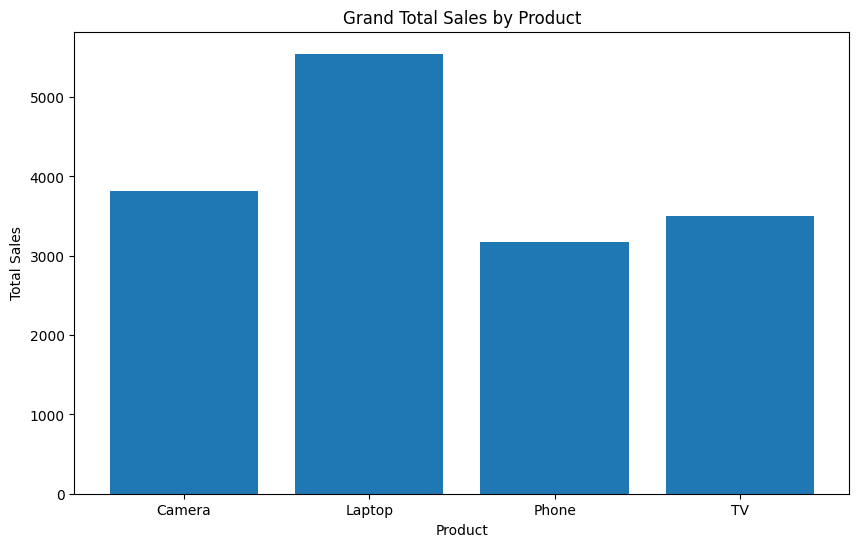

'/content/exports/charts/temp_chart.png'

In [ ]:
sdf.chat("Plot a barchart of grand total sales by product")

### Custom implementation

In [ ]:
def visuals_gpt(natural_language_query, dataframe):

  df = dataframe
  system_prompt = """

  ROLE: You are a Python code generator.

  TASK: I'll give you a pandas dataframe and a description about a visualization I need for this data.
  You will take my description and translate it into functional Python code that works with the dataset I provided you.

  CONTEXT: ## My dataframe is called `df`. Here are the first 30 rows indicated in triple backticks:
  ```
  {}
  ```

  OUTPUT: Return ONLY the Python code in plain text, no markdown. Skip pre- and post text.

  """.format(dataframe.head(30))

  response = client.chat.completions.create(
  model="gpt-3.5-turbo-1106",
  response_format={ "type": "json_object" },
  messages=[
    {"role": "system", "content": system_prompt + "Respond in JSON. Key name 'python_code"},
    {"role": "user", "content": str(natural_language_query)}
  ],
  temperature=0.0
  )
  script = json.loads(response.choices[0].message.content)['python_code']
  print(script)
  visual = exec(script)
  return(visual)

**Question:**
<blockquote>total sales by product as barchart, x-labels rotated 45 degrees, different colors by product name</blockquote>

total sales by product as barchart, x-labels rotated 45 degrees, different colors by product name
import matplotlib.pyplot as plt

# Grouping the data by product_name and summing the total_sales
product_sales = df.groupby('product_name')['total_sales'].sum()

# Creating a bar chart with rotated x-labels and different colors
product_sales.plot(kind='bar', color=['blue', 'green', 'orange', 'red'], alpha=0.75)
plt.xticks(rotation=45)
plt.xlabel('Product Name')
plt.ylabel('Total Sales')
plt.title('Total Sales by Product')
plt.show()


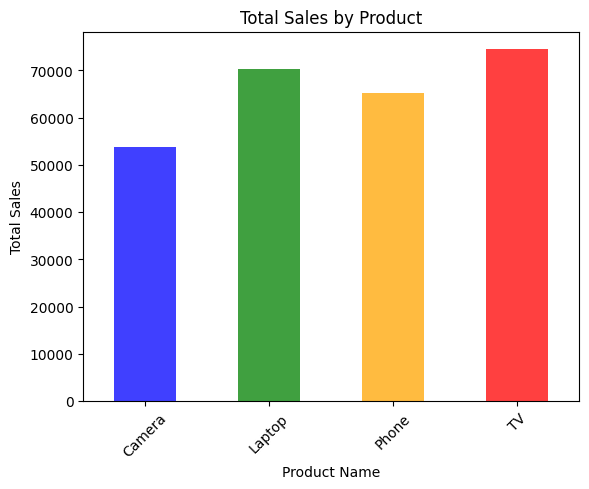

In [ ]:
visuals_gpt(input(), products_df)

Advanced plotting

**Question:**
<blockquote>Barcharts sales by customer ID for the top 5 customers, grouped by product type</blockquote>

Barcharts sales by customer ID for the top 5 customers, grouped by product type
import pandas as pd
import matplotlib.pyplot as plt

# Grouping the data by customer_id and product_name, then summing the total_sales
grouped_df = df.groupby(['customer_id', 'product_name'])['total_sales'].sum().unstack()

# Selecting the top 5 customers based on total sales
top_5_customers = df.groupby('customer_id')['total_sales'].sum().nlargest(5).index

# Filtering the grouped data for the top 5 customers
top_5_grouped_df = grouped_df.loc[top_5_customers]

# Plotting the bar chart
top_5_grouped_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sales by Customer ID for Top 5 Customers, Grouped by Product Type')
plt.xlabel('Customer ID')
plt.ylabel('Total Sales')
plt.show()


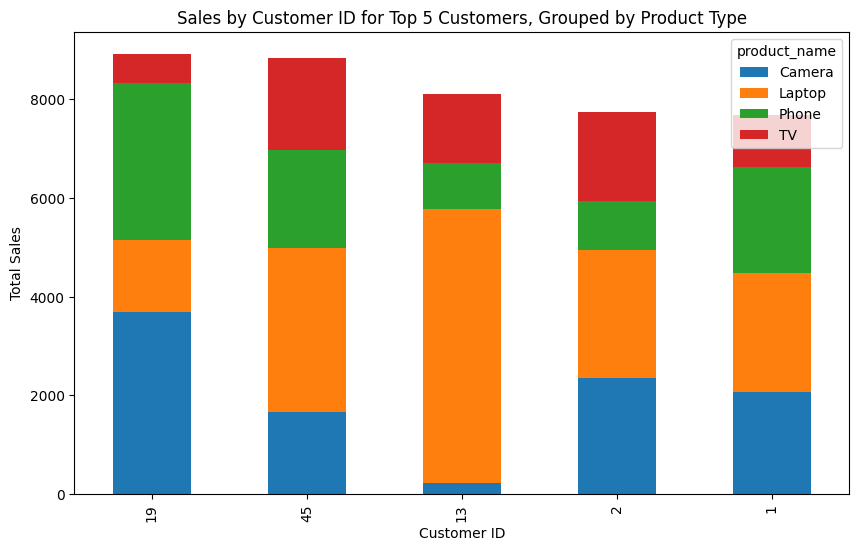

In [ ]:
visuals_gpt(input(), products_df)

**Question:**
<blockquote>Draw a Scatterplot. x-axis = amount of products sold, y-axis = grand total sales per product. One Point= product type</blockquote>

Draw a Scatterplot. x-axis = amount of products sold, y-axis = grand total sales per product. One Point= product type
import matplotlib.pyplot as plt

# Grouping the data by product_name and calculating the total sales and count
product_group = df.groupby('product_name').agg({'total_sales': 'sum', 'customer_id': 'count'})

# Creating the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(product_group['customer_id'], product_group['total_sales'], s=100, alpha=0.5)

# Adding labels and title
plt.xlabel('Amount of Products Sold')
plt.ylabel('Grand Total Sales per Product')
plt.title('Scatterplot of Total Sales vs. Products Sold')

# Adding annotations for each point
for i, product in enumerate(product_group.index):
    plt.annotate(product, (product_group['customer_id'].iloc[i], product_group['total_sales'].iloc[i]), textcoords='offset points', xytext=(5,5), ha='center')

# Displaying the plot
plt.show()


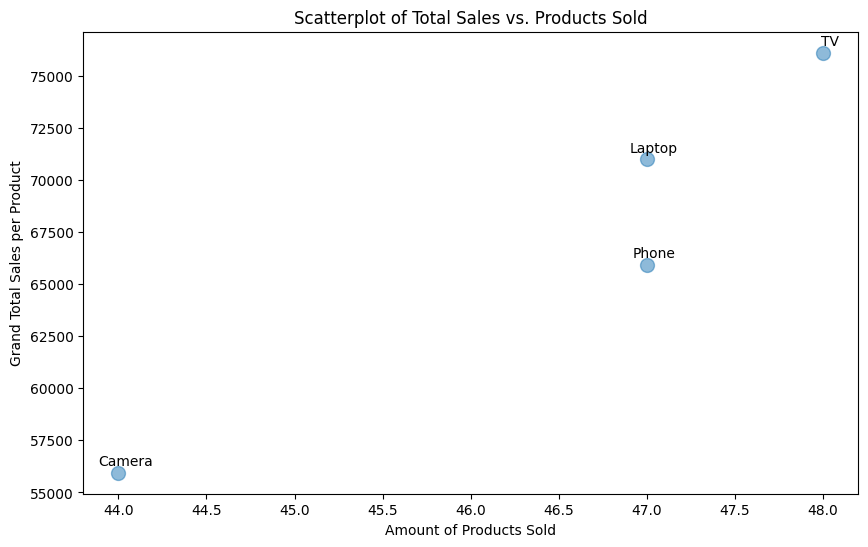

In [ ]:
visuals_gpt(input(), products_df)

## Use Case 5 - Create an EDA

In [ ]:
def eda_gpt(dataframe, target_col_name):

  df = dataframe
  system_prompt = f"""

  ROLE: You are a Python code generator.

  TASK: Please provide a detailed analysis of this dataframe, including summary statistics for each column, relationships with the target column, and suggestions for visualizations to better understand the data.

  CONTEXT: ## My dataframe is called `df`. The target column is {target_col_name}.  Here are the first 30 rows indicated in triple backticks:
  ```
  {dataframe.head(30)}
  ```

  OUTPUT: Return ONLY the Python code in plain text, no markdown. Skip pre- and post text.

  """

  response = client.chat.completions.create(
  model="gpt-4-1106-preview",
  response_format={ "type": "json_object" },
  messages=[
    {"role": "system", "content": system_prompt + "Respond in JSON. Key name 'python_code"},
  ],
  temperature=0.0
  )
  script = json.loads(response.choices[0].message.content)['python_code']
  print(script)
  eda = exec(script)
  return(eda)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already loaded as a pandas DataFrame

# Summary statistics for each column
summary_stats = df.describe(include='all')

# Frequency of each product
product_counts = df['product_name'].value_counts()

# Total sales statistics grouped by product
sales_by_product = df.groupby('product_name')['total_sales'].describe()

# Relationships with the target column (product_name)
# We can use groupby to see how total_sales varies with different products
sales_relation = df.groupby('product_name')['total_sales'].mean()

# Visualizations
# Bar plot for product counts
sns.countplot(data=df, x='product_name')
plt.title('Product Frequency')
plt.show()

# Box plot for total_sales by product
sns.boxplot(data=df, x='product_name', y='total_sales')
plt.title('Total Sales by Product')
plt.show()

# Pairplot to explore relationships between numerical variables
sns.pairplot(df, hue='product_name')
plt.show()

# Heatmap 

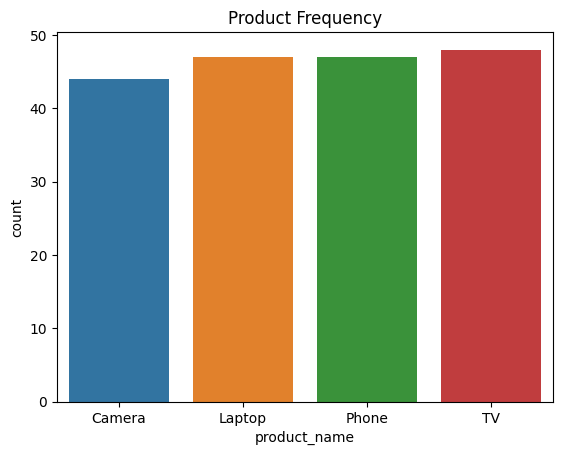

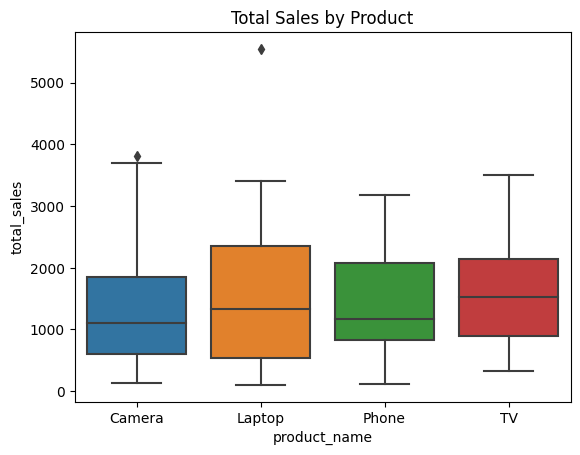

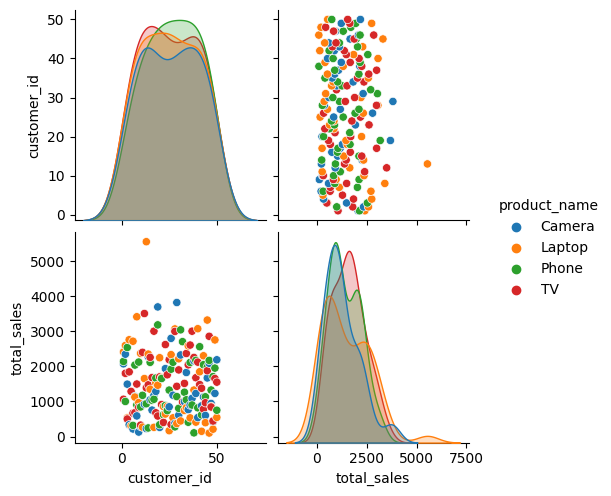

<string>:36: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


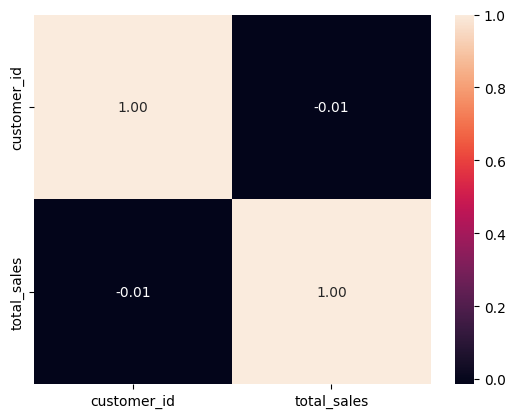

In [ ]:
eda_gpt(products_df, "product_name")

## Limitations

* Always check your results!
* Remember: This is an augmented scenario!
* You're in charge.